In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim

In [19]:
iris = load_iris()

X = iris.data
y = iris.target

In [20]:
sc = StandardScaler()
X = sc.fit_transform(X)

#### PCA

In [21]:
pca = PCA(n_components = 3, random_state = 42)
X_pca = pca.fit_transform(X)
X_pca_reconstructed = pca.inverse_transform(X_pca)
pca_mse = mean_squared_error(X, X_pca_reconstructed)

print(f'Reconstruction MSE using PCA : {pca_mse}')

Reconstruction MSE using PCA : 0.005178709107154799


#### AutoEncoder

In [22]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # input data -> latent space (4(x) -> 2(z))
        self.encoder = nn.Sequential(            
            nn.Linear(4, 3),
            nn.ReLU(), 
            nn.Linear(3, 2)
        )
        # latent space -> reconstructed input (2(z) -> 4(x*))
        self.decoder = nn.Sequential(
            nn.Linear(2, 3),
            nn.ReLU(),
            nn.Linear(3, 4)
        )
    
    def forward(self, x):
        z = self.encoder(x)
        output = self.decoder(z)
        return z, output

In [23]:
X_tensor = torch.tensor(X, dtype = torch.float32)
model = AutoEncoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(
    params = model.parameters(),
    lr = 0.01
)

In [24]:
# Training Loop
for epoch in range(500):
    # reset gradients after backpropagation at each epoch
    optimizer.zero_grad()
    latent_representation, reconstructed = model(X_tensor)
    loss = criterion(reconstructed, X_tensor) 
    # Backpropagation and gradient based updations
    loss.backward()
    optimizer.step()

# Encode and Reconstruct 
with torch.no_grad():
    x_auto_encoded, x_auto_reconstructed = model(X_tensor)
    auto_mse = mean_squared_error(X, x_auto_reconstructed.numpy())

In [25]:
print(f'Reconstruction MSE using AutoEncoder : {auto_mse}')

Reconstruction MSE using AutoEncoder : 0.048940583871441984


### Visualization

In [26]:
def plot_2d(X_data, title, mse):
    plt.figure(figsize = (6, 6))
    sns.scatterplot(x = X_data[:, 0], y = X_data[:, 1], hue = iris.target_names[y], palette = 'bright')
    plt.title(f'{title}\nMSE : {mse}')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend()
    plt.grid(visible = True)
    plt.tight_layout()
    plt.show()

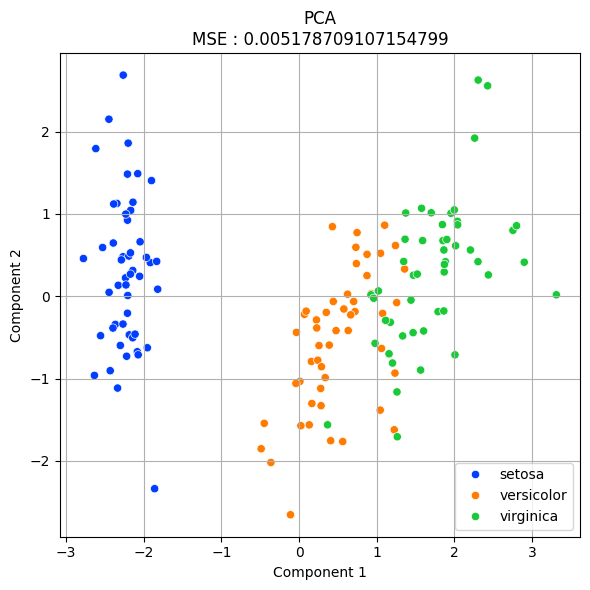

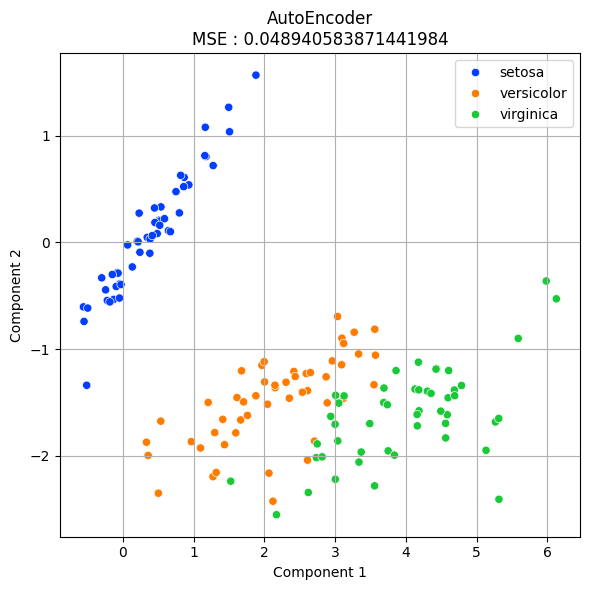

In [27]:
plot_2d(X_pca, "PCA", pca_mse)
plot_2d(x_auto_encoded.numpy(), "AutoEncoder", auto_mse)

### Conclusion : 

#### On small, linearly separable datasets like Iris, PCA may beat Autoencoders in reconstruction error — not because AE is bad, but because PCA is a near-perfect match for the structure of the data.